# Data Collection Phase

In this phase , data is collected from various social media sites like Twitter and Reddit.

## 1. Collecting Data from Twitter using tweepy API

In [78]:
import tweepy
import csv
import pandas as pd
# input your credentials here
consumer_key = 'gIENuDUpWlld1sCNPGz5UrLYR'
consumer_secret = 'uwRPNA1j4reQlxLw0LA6j8ha8CcofUXYtZkIHZE7rJOv0EtvpP'
access_token = '183906186-nOLz1Ivzed3AGycbaBAiTL7zE8vXkW7L3Lf06tsn'
access_token_secret = 'gRn4hJiyQJLx7N1nLDvzghFse3poWdvsMimBHRJaKlKXR'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, wait_on_rate_limit=True)
csvFile = open('twitterdata.csv', 'a')
# Use csv Writer
csvWriter = csv.writer(csvFile)

for tweet in tweepy.Cursor(api.search, q="#indvsaus", count=50,
                           lang="en",
                           since="2020-01-01").items():
    csvWriter.writerow([tweet.text.encode('utf-8')])


## 2. Collecting data from Reddit using Praw API

In [ ]:
import praw
import pandas as pd
from praw.models import MoreComments
reddit = praw.Reddit(client_id='MjOYmV5QB4Q8bw', client_secret='Ha-Bem-WhpBXOFu6sQExGW1u760', user_agent='Scraping Example')

"""
# get 10 hot posts from the MachineLearning subreddit
hot_posts = reddit.subreddit('Cricket').hot(limit=10)
for post in hot_posts:
    print(post.title)
"""
#comments = []
comments=""
submission = reddit.submission(id="f1zmjl")
submission.comments.replace_more(limit=0)
for top_level_comment in submission.comments:
    comments = comments + top_level_comment.body
    #comments.append([top_level_comment.body])
#comments = pd.DataFrame(comments,columns=['comment'])
print(comments)
#comments.to_pickle('redditdataset.pkl')
comments.to_csv('redditdataset.csv', sep='.', encoding='utf-8', index=False)

In [ ]:
from nltk.probability import FreqDist
fdist = FreqDist(tokenized_word)
print(fdist)
fdist.most_common(2)

In [ ]:
# Frequency Distribution Plot
import matplotlib.pyplot as plt
fdist.plot(30,cumulative=False)
plt.show()


# Data Processing Phase

Performing data mining algorithms on collected data to retrieve information.



## Applying TF-IDF to collected dataset

In [41]:
with open('twitterdata.csv', 'r') as twitterfile:
    twittertext = twitterfile.readlines()
# Converting List to String
twitterdoc = ' '.join(map(str, twittertext))

In [42]:
with open('redditdataset.csv', 'r') as redditfile:
    reddittext = redditfile.readlines()
# Converting List to String
redditdata = ' '.join(map(str, reddittext))

In [43]:
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
tokenized_text=sent_tokenize(redditdata)
tokenized_word=word_tokenize(redditdata)

In [44]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words=set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/warlock/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [45]:
redditfilter = []
for w in tokenized_word:
    if w not in stop_words:
        redditfilter.append(w)
rd = ' '.join(map(str, redditfilter))

In [46]:
import re
rwo = re.findall(r'\w+', rd)
rdi = [i for i in rwo if not i.isdigit()]
fw = [i for i in rdi if len(i) > 1]
redditdoc = ' '.join(map(str, fw))

In [47]:
# Slicing the string into two to perform TF - IDF Algorithm
#str_one, str_two = filt_sent_string[:len(filt_sent_string)//2],filt_sent_string[len(filt_sent_string)//2:] 


In [48]:
import math
from textblob import TextBlob as tb

def tf(word, blob):
    return blob.words.count(word) / len(blob.words)

def n_containing(word, bloblist):
    return sum(1 for blob in bloblist if word in blob)

def idf(word, bloblist):
    return math.log(len(bloblist) / (1 + n_containing(word, bloblist)))

def tfidf(word, blob, bloblist):
    return tf(word, blob) * idf(word, bloblist)

document1 = tb(twitterdoc)

document2 = tb(redditdoc)

bloblist = [document1, document2]
for i, blob in enumerate(bloblist):
    print("Top words in document {}".format(i + 1))
    scores = {word: tfidf(word, blob, bloblist) for word in blob.words}
    sorted_words = sorted(scores.items(), key=lambda x: x[1], reverse=True)
    for word, score in sorted_words[:5]:
        #print("Word: {}, TF-IDF: {}".format(word, round(score, 5)))
        if not word.isdigit():
            print(word)

Top words in document 1
Tweets
Kumble
70.5
Top words in document 2
comment
So
worst
series
Kohli


In [49]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()

In [50]:
response = tfidf.fit_transform([twitterdoc, redditdoc])

In [51]:
tfidfwords = []
feature_names = tfidf.get_feature_names()
for col in response.nonzero()[1]:
    if not feature_names[col].isdigit() and len(feature_names[col]) > 3 and int((response[0, col]) * 10) % 10 != 0:
        print (feature_names[col], ' - ', response[0, col])
        tfidfwords.append(feature_names[col])

symonds  -  0.19406231545265296
hussey  -  0.1542546610008267
tendulkar  -  0.11329389601257225
dravid  -  0.11683433026296514
india  -  0.27615387153064486
tendulkar  -  0.11329389601257225
dravid  -  0.11683433026296514
india  -  0.27615387153064486


In [52]:
print("Fans Mostly discussed about : ",tfidfwords)

Fans Mostly discussed about :  ['symonds', 'hussey', 'tendulkar', 'dravid', 'india', 'tendulkar', 'dravid', 'india']


In [ ]:
#combining the reddit & twitter data for retrieving key comments
finaldataset = twitterdoc + redditdata
print(finaldataset)

In [64]:
re.findall(r"([^.]*?kohli[^.]*\.)",finaldataset)

['\n Madarchod Mode activated\n To get rid of the bilateral bully tag kohli has decided he will only score 100s in the world cup.',
 '"\n Pretty unsual stuff this from kohli.',
 ' Pretty unlike the restless kohli we know\n james+ anderson= Jamieson\n "NZ: has slight advantage \n \n Ian Smith: aggressively licks lips"\n Shaw reminds me of Sehawag.',
 '\n Apparently kohli is very overrated in LOIs.']

# Sentiment Analysis using NLTK

In [3]:
import pandas as pd
messages = [line.rstrip() for line in open("redditdataset.csv")]
data = pd.read_csv("redditdataset.csv",sep="\n",names=["message"])

In [7]:
data["message"][1]
#just to check if datacorpus is loaded currectly.

'So this is the worst series of Kohli like in years.'

In [11]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/warlock/nltk_data...


True

In [12]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [13]:
sid = SentimentIntensityAnalyzer()

In [15]:
summary = {"positive":0,"neutral":0,"negative":0}
for x in messages: 
    ss = sid.polarity_scores(x)
    if ss["compound"] == 0.0: 
        summary["neutral"] +=1
    elif ss["compound"] > 0.0:
        summary["positive"] +=1
    else:
        summary["negative"] +=1
print(summary)

{'positive': 206, 'neutral': 448, 'negative': 140}


In [16]:
type(summary)

dict

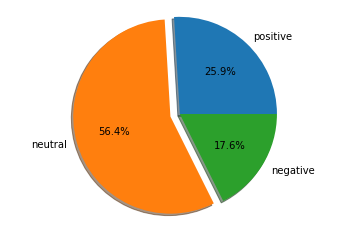

In [51]:
import matplotlib.pyplot as plt
labels = tuple(summary.keys())
sizes = list(summary.values())
explode = (0, 0.1, 0)
plt.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True)
plt.axis('equal')
plt.show()